<a href="https://colab.research.google.com/github/Tirthalg/Codify/blob/main/Fake_Audio_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa tensorflow --quiet



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# from google.colab import drive
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings('ignore')


In [ ]:
# drive.mount('/content/drive')

In [ ]:
original_audio_dir = 'E:/generated_audio/ljspeech_melgan/'
fake_audio_dir = 'E:/LJSpeech-1.1/wavs/'

file_paths = []
labels = []

for filename in os.listdir(fake_audio_dir):
    if filename.endswith('.wav') or filename.endswith('.mp3'):
        file_paths.append(os.path.join(fake_audio_dir, filename))
        labels.append('spoof')

for filename in os.listdir(original_audio_dir):
    if filename.endswith('.wav') or filename.endswith('.mp3'):
        file_paths.append(os.path.join(original_audio_dir, filename))
        labels.append('bona-fide')

data = {'file': file_paths, 'label': labels}
df = pd.DataFrame(data)

csv_file_path = '../audio_labels.csv'
df.to_csv(csv_file_path, index=False)
print(f"CSV file created at: {csv_file_path}")

CSV file created at: ../audio_labels.csv


In [ ]:
dfs = []
csv_file_path = '../audio_labels.csv'
dfs.append(pd.read_csv(csv_file_path))

csv_file_path = '../release_in_the_wild/meta.csv'
dfs.append(pd.read_csv(csv_file_path).drop('speaker',axis='columns'))

df = pd.concat(dfs, ignore_index=True)

print(df.head(-1))

                                      file      label
0      E:/LJSpeech-1.1/wavs/LJ001-0001.wav      spoof
1      E:/LJSpeech-1.1/wavs/LJ001-0002.wav      spoof
2      E:/LJSpeech-1.1/wavs/LJ001-0003.wav      spoof
3      E:/LJSpeech-1.1/wavs/LJ001-0004.wav      spoof
4      E:/LJSpeech-1.1/wavs/LJ001-0005.wav      spoof
...                                    ...        ...
57973                            31773.wav      spoof
57974                            31774.wav  bona-fide
57975                            31775.wav  bona-fide
57976                            31776.wav  bona-fide
57977                            31777.wav  bona-fide

[57978 rows x 2 columns]


In [ ]:
df_shuffled = df.sample(frac=1, random_state=512).reset_index(drop=True)
print(df_shuffled.head())

                                  file      label
0                             4872.wav  bona-fide
1                            16146.wav      spoof
2                            29316.wav      spoof
3                             6650.wav  bona-fide
4  E:/LJSpeech-1.1/wavs/LJ036-0111.wav      spoof


In [ ]:
def extract_features(file_path):
    try:
        nfft = 512
        target_length = 200

        y, sr = librosa.load(file_path, sr=None)
        if len(y) < 1024:
            y = np.pad(y, (0, 1024 - len(y)), mode='constant')
        chroma = librosa.feature.chroma_stft(y=y, sr=sr,n_fft=nfft)
        mean_value = np.mean(chroma)
        chroma_mean = np.mean(chroma.T, axis=0)
        chroma = np.pad(chroma, ((0, 0), (0, max(0, target_length - chroma.shape[1]))), mode='constant',constant_values=mean_value)[:, :target_length]

        mfccs = librosa.feature.mfcc(y=y, sr=sr,n_fft=nfft)
        mean_value = np.mean(mfccs)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        mfccs = np.pad(mfccs, ((0, 0), (0, max(0, target_length - mfccs.shape[1]))), mode='constant',constant_values=mean_value)[:, :target_length]

        spect_band = librosa.feature.spectral_bandwidth(y=y,sr=sr,n_fft=nfft)
        mean_value = np.mean(spect_band)
        specb_mean = np.mean(spect_band.T, axis=0)
        spect_band = np.pad(spect_band, ((0, 0), (0, max(0, target_length - spect_band.shape[1]))), mode='constant',constant_values=mean_value)[:,:target_length]

        spect_cen = librosa.feature.spectral_centroid(y=y,sr=sr,n_fft=nfft)
        mean_value = np.mean(spect_cen)
        specc_mean = np.mean(spect_cen.T,axis=0)
        spect_cen = np.pad(spect_cen, ((0, 0), (0, max(0, target_length - spect_cen.shape[1]))), mode='constant',constant_values=mean_value)[:,:target_length]

        spect_flat = librosa.feature.spectral_flatness(y=y,n_fft=nfft)
        mean_value = np.mean(spect_flat)
        specf_mean = np.mean(spect_flat.T , axis=0)
        spect_flat = np.pad(spect_flat, ((0, 0), (0, max(0, target_length - spect_flat.shape[1]))), mode='constant',constant_values=mean_value)[:,:target_length]

        spect_con = librosa.feature.spectral_contrast(y=y,sr=sr,n_fft=nfft)
        mean_value = np.mean(spect_con)
        specco_mean = np.mean(spect_con.T, axis=0)
        spect_con = np.pad(spect_con, ((0, 0), (0, max(0, target_length - spect_con.shape[1]))), mode='constant',constant_values=mean_value)[:, :target_length]

        tonz = librosa.feature.tonnetz(y=y,sr=sr)
        mean_value = np.mean(tonz)
        ton_mean = np.mean(tonz.T, axis = 0)
        tonz = np.pad(tonz, ((0, 0), (0, max(0, target_length - tonz.shape[1]))), mode='constant',constant_values=mean_value)[:, :target_length]

        times = librosa.times_like(spect_cen)

        return {
            'y': y,
            'sr': sr,
            'chroma': chroma,
            'chroma_mean': chroma_mean,
            'mfccs': mfccs,
            'mfccs_mean': mfccs_mean,
            'spect_band': spect_band,
            'specb_mean': specb_mean,
            'spect_cen': spect_cen,
            'specc_mean': specc_mean,
            'spect_flat': spect_flat,
            'specf_mean': specf_mean,
            'spect_con': spect_con,
            'specco_mean': specco_mean,
            'tonz': tonz,
            'ton_mean': ton_mean,
            'times': times
        }

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [ ]:
base_path = '../release_in_the_wild/'
count = 0
for i in tqdm(range(len(df_shuffled)), desc="Extracting Features"):
    if len(df_shuffled['file'][i])>10:
        count = count + extract_features(df_shuffled['file'][i])
    else:
        count = count + extract_features(base_path+df_shuffled['file'][i])
print(count)
print(count/len(df_shuffled))

In [ ]:
# base_path = '/content/drive/MyDrive/release_in_the_wild/'
base_path = '../release_in_the_wild/'
original = extract_features(base_path+df_shuffled['file'][0]),df_shuffled['label'][0]
fake = extract_features(base_path+df_shuffled['file'][2]),df_shuffled['label'][2]
# print(fake)
# print(original)
df_shuffled.shape
print(fake[0]['sr'])
print(fake[0]['mfccs'].shape,fake[0]['chroma'].shape,fake[0]['spect_band'].shape,fake[0]['spect_cen'].shape,fake[0]['spect_flat'].shape,fake[0]['spect_con'].shape,fake[0]['tonz'].shape)
print(original[0]['mfccs'].shape,original[0]['chroma'].shape,original[0]['spect_band'].shape,original[0]['spect_cen'].shape,original[0]['spect_flat'].shape,original[0]['spect_con'].shape,original[0]['tonz'].shape)

16000
(20, 200) (12, 200) (1, 200) (1, 200) (1, 200) (7, 200) (6, 200)
(20, 200) (12, 200) (1, 200) (1, 200) (1, 200) (7, 200) (6, 200)


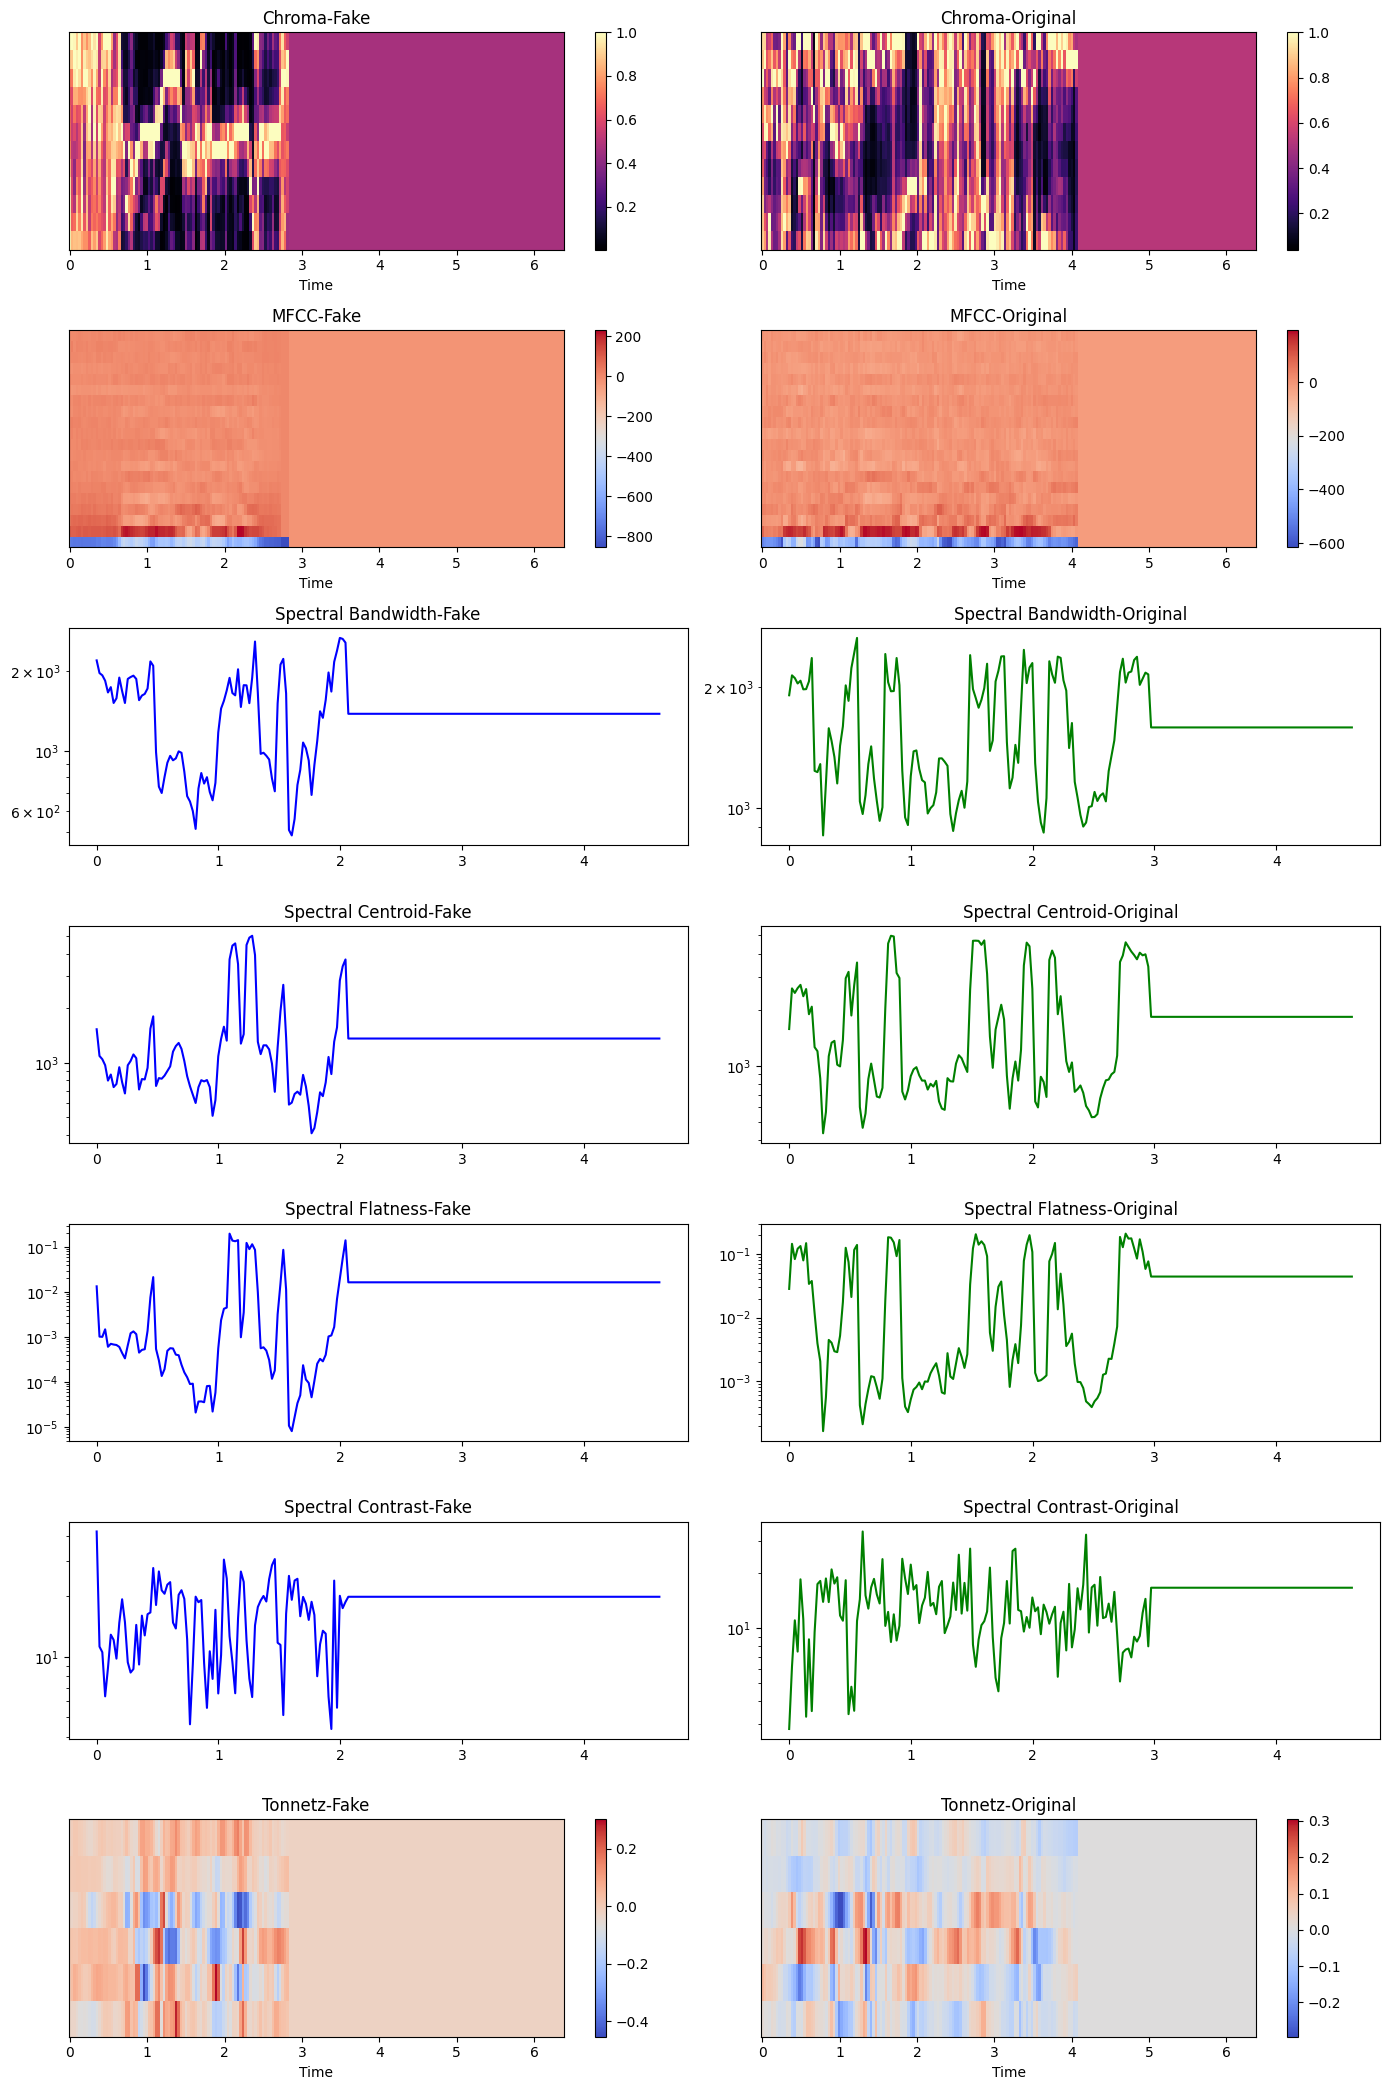

In [ ]:
plt.figure(figsize=(14, 21))
plt.subplot(7, 2, 1)
librosa.display.specshow(fake[0]['chroma'], sr=fake[0]['sr'], x_axis='time')
plt.title('Chroma-Fake')
plt.colorbar()

plt.subplot(7, 2, 2)
librosa.display.specshow(original[0]['chroma'], sr=original[0]['sr'], x_axis='time')
plt.title('Chroma-Original')
plt.colorbar()

plt.subplot(7, 2, 3)
librosa.display.specshow(fake[0]['mfccs'], sr=fake[0]['sr'], x_axis='time')
plt.title('MFCC-Fake')
plt.colorbar()

plt.subplot(7, 2, 4)
librosa.display.specshow(original[0]['mfccs'], sr=original[0]['sr'], x_axis='time')
plt.title('MFCC-Original')
plt.colorbar()

plt.subplot(7, 2, 5)
plt.semilogy(fake[0]['times'], fake[0]['spect_band'][0], color='b')
plt.title('Spectral Bandwidth-Fake')

plt.subplot(7, 2, 6)
plt.semilogy(original[0]['times'], original[0]['spect_band'][0], color='g')
plt.title('Spectral Bandwidth-Original')

plt.subplot(7, 2, 7)
plt.semilogy(fake[0]['times'], fake[0]['spect_cen'][0], color='b')
plt.title('Spectral Centroid-Fake')

plt.subplot(7, 2, 8)
plt.semilogy(original[0]['times'], original[0]['spect_cen'][0], color='g')
plt.title('Spectral Centroid-Original')

plt.subplot(7, 2, 9)
plt.semilogy(fake[0]['times'], fake[0]['spect_flat'][0], color='b')
plt.title('Spectral Flatness-Fake')

plt.subplot(7, 2, 10)
plt.semilogy(original[0]['times'], original[0]['spect_flat'][0], color='g')
plt.title('Spectral Flatness-Original')

plt.subplot(7, 2, 11)
plt.semilogy(fake[0]['times'], fake[0]['spect_con'][0], color='b')
plt.title('Spectral Contrast-Fake')

plt.subplot(7, 2, 12)
plt.semilogy(original[0]['times'], original[0]['spect_con'][0], color='g')
plt.title('Spectral Contrast-Original')

plt.subplot(7, 2, 13)
librosa.display.specshow(fake[0]['tonz'], sr=fake[0]['sr'], x_axis='time')
plt.title('Tonnetz-Fake')
plt.colorbar()

plt.subplot(7, 2, 14)
librosa.display.specshow(original[0]['tonz'], sr=original[0]['sr'], x_axis='time')
plt.title('Tonnetz-Original')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
means_list = []
means_labellist = []
features_list = []
labels_list = []
target_length = 100

with open("../features_detailed.csv", "w") as features_file:
    header = True
    for i in tqdm(range(len(df_shuffled)), desc="Extracting Features"):
        if len(df_shuffled['file'][i])>10:
            features = extract_features(df_shuffled['file'][i])
        else:
            features = extract_features(base_path+df_shuffled['file'][i])
        if features is not None:
            means_list.append(np.hstack([
                features['chroma_mean'], features['mfccs_mean'], features['specb_mean'], features['specc_mean'],
                features['specf_mean'], features['specco_mean'], features['ton_mean']
            ]))
            means_labellist.append(df_shuffled['label'][i])

            features_list.append(np.hstack([
                features['chroma'].flatten(), features['mfccs'].flatten(), features['spect_band'].flatten(),
                features['spect_cen'].flatten(), features['spect_flat'].flatten(), features['spect_con'].flatten(),
                features['tonz'].flatten()
            ]))
            labels_list.append(df_shuffled['label'][i])


        if (i+1)%1000 == 0:
            df_means_chunk = pd.DataFrame(np.array(features_list))
            df_labels_chunk = pd.DataFrame(labels_list, columns=["label"])

            df_means_chunk = pd.concat([df_means_chunk, df_labels_chunk], axis=1)
            df_means_chunk.to_csv(features_file, index=False,mode='a',header=header)
            header = False

            features_list = []
            labels_list = []

df_means = pd.DataFrame(means_list)
df_features = pd.DataFrame(np.array(features_list))
df_labels = pd.DataFrame(labels_list, columns=["label"])
df_m_labels = pd.DataFrame(means_labellist, columns=["label"])

df_means = pd.concat([df_means, df_m_labels], axis=1)
df_features = pd.concat([df_features, df_labels], axis=1)

df_means.to_csv("../features_means.csv", index=False,header=False)
df_features.to_csv("../features_detailed.csv", index=False,mode='a',header=False)

print("Features and labels saved to CSV files.")


Extracting Features: 100%|██████████| 57979/57979 [2:12:06<00:00,  7.31it/s]   


Features and labels saved to CSV files.


In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/features_means.csv')
df = pd.read_csv('../features_means.csv')

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)
print(df.head)
df.shape

<bound method NDFrame.head of               0         1         2         3         4         5         6  \
0      0.630989  0.531217  0.472180  0.435208  0.373213  0.378555  0.466286   
1      0.425741  0.551324  0.653286  0.439349  0.354702  0.510976  0.398267   
2      0.357548  0.369638  0.382511  0.405396  0.531212  0.706408  0.695174   
3      0.354357  0.296616  0.312174  0.407455  0.479859  0.596367  0.598569   
4      0.412422  0.412655  0.420242  0.412985  0.398114  0.412156  0.452070   
...         ...       ...       ...       ...       ...       ...       ...   
57974  0.542570  0.467158  0.419646  0.383427  0.377018  0.395622  0.384919   
57975  0.515136  0.423495  0.387756  0.399902  0.422037  0.400187  0.374959   
57976  0.505593  0.422137  0.395684  0.402420  0.394979  0.416789  0.397452   
57977  0.478622  0.542767  0.592662  0.486520  0.428808  0.475713  0.569772   
57978  0.627832  0.493440  0.413118  0.397875  0.365915  0.474705  0.506772   

              7      

(57979, 49)

Model: GradientBoostingClassifier
Accuracy: 97.05
Precision: 97.44
Recall: 95.69
F1 Score: 96.56

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6586
           1       0.97      0.96      0.97      5010

    accuracy                           0.97     11596
   macro avg       0.97      0.97      0.97     11596
weighted avg       0.97      0.97      0.97     11596



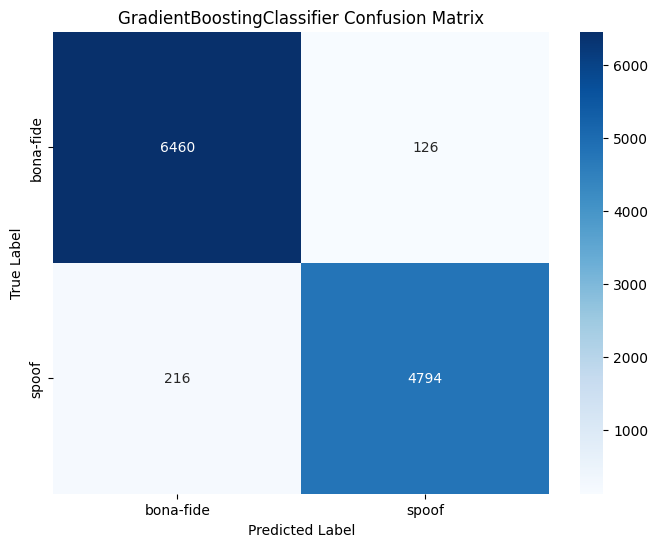

Model: RandomForestClassifier
Accuracy: 97.81
Precision: 98.33
Recall: 96.57
F1 Score: 97.44

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6586
           1       0.98      0.97      0.97      5010

    accuracy                           0.98     11596
   macro avg       0.98      0.98      0.98     11596
weighted avg       0.98      0.98      0.98     11596



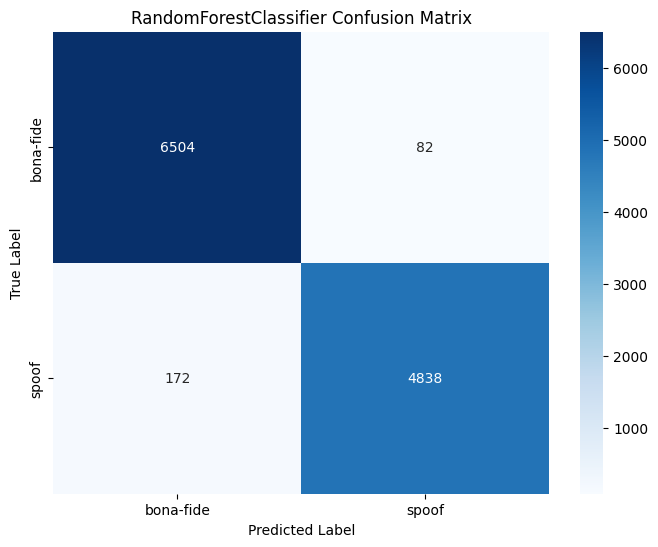

Model: LogisticRegression
Accuracy: 91.97
Precision: 91.04
Recall: 90.30
F1 Score: 90.67

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6586
           1       0.91      0.90      0.91      5010

    accuracy                           0.92     11596
   macro avg       0.92      0.92      0.92     11596
weighted avg       0.92      0.92      0.92     11596



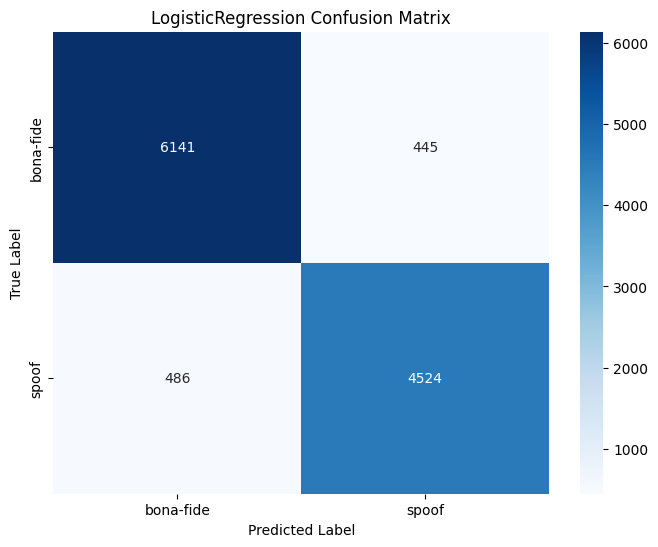

Model: MLPClassifier
Accuracy: 94.92
Precision: 90.10
Recall: 99.14
F1 Score: 94.40

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      6586
           1       0.90      0.99      0.94      5010

    accuracy                           0.95     11596
   macro avg       0.95      0.95      0.95     11596
weighted avg       0.95      0.95      0.95     11596



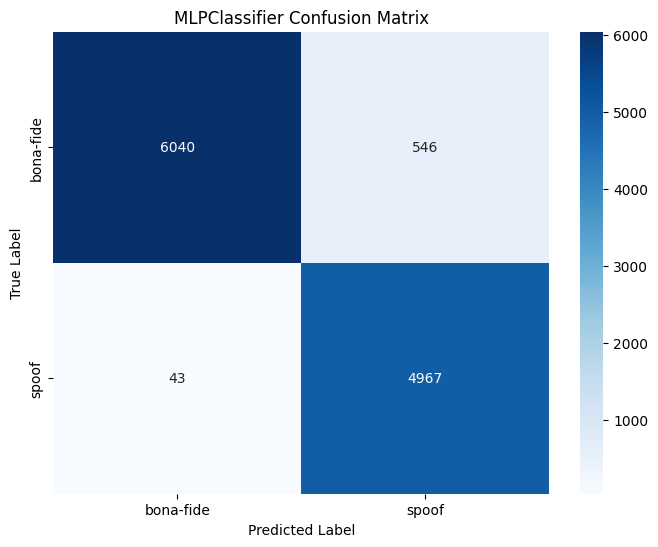

In [ ]:
classifiers = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network (MLP)": MLPClassifier(),
}
def save_confusion_matrix_heatmap(conf_matrix, model_name, label_encoder):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')

    plt.show()



def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy*100:.2f}")
    print(f"Precision: {precision*100:.2f}")
    print(f"Recall: {recall*100:.2f}")
    print(f"F1 Score: {f1*100:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    save_confusion_matrix_heatmap(conf_matrix,model.__class__.__name__,label_encoder)


for name, model in classifiers.items():
    evaluate_model(model)

In [ ]:

from keras import layers

data = pd.read_csv('../features_detailed.csv')
data = data[data.iloc[:, -1]  != 'label']
print(data.shape)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X = X.reshape(-1, 48, 200)
print("X shape:", X.shape)

y = np.array(y)
print("y shape:", y.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)


(57979, 9601)
X shape: (57979, 48, 200)
y shape: (57979,)


In [ ]:
from keras import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model = Sequential([
    layers.Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(48,200)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Reshape((-1, 8)),
    layers.LSTM(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
def scheduler(epoch, lr):
    return lr * 0.8 if epoch > 0 and epoch%5 == 0 else lr
lr_scheduler = LearningRateScheduler(scheduler)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0004), metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[lr_scheduler])

Epoch 1/20
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5316 - loss: 32.6335 - val_accuracy: 0.5537 - val_loss: 0.9289 - learning_rate: 4.0000e-04
Epoch 2/20
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4933 - loss: 0.8028 - val_accuracy: 0.4509 - val_loss: 0.7077 - learning_rate: 4.0000e-04
Epoch 3/20
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5002 - loss: 0.7388 - val_accuracy: 0.5689 - val_loss: 0.6879 - learning_rate: 4.0000e-04
Epoch 4/20
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5026 - loss: 0.7376 - val_accuracy: 0.5495 - val_loss: 0.6914 - learning_rate: 4.0000e-04
Epoch 5/20
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4957 - loss: 0.7293 - val_accuracy: 0.5692 - val_loss: 0.6961 - learning_rate: 4.0000e-04
Epoch 6/20
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5015 - loss: 0.7137 - val_accuracy: 0.5694 - val_loss: 0.6924 - learning_rate: 3.2000e-04
Epoch 7/20
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/s

In [ ]:
model.save('../my_model.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('../my_model.keras')

model.optimizer.learning_rate.assign(0.00000001)
def scheduler(epoch, lr):
    return lr * 0.8 if epoch > 0 and epoch%5 == 0 else lr
lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[lr_scheduler])


Epoch 1/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8572 - loss: 0.3289 - val_accuracy: 0.8408 - val_loss: 0.3580 - learning_rate: 1.0000e-08
Epoch 2/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8549 - loss: 0.3371 - val_accuracy: 0.8409 - val_loss: 0.3579 - learning_rate: 1.0000e-08
Epoch 3/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8561 - loss: 0.3335 - val_accuracy: 0.8411 - val_loss: 0.3579 - learning_rate: 1.0000e-08
Epoch 4/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8567 - loss: 0.3327 - val_accuracy: 0.8410 - val_loss: 0.3579 - learning_rate: 1.0000e-08
Epoch 5/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8577 - loss: 0.3313 - val_accuracy: 0.8409 - val_loss: 0.3579 - learning_rate: 1.0000e-08
Epoch 6/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8565 - loss: 0.3339 - val_accuracy: 0.8410 - val_loss: 0.3580 - learning_rate: 8.0000e-09
Epoch 7/50
2899/2899 ━━━━━━━━━━━━━━━━━━━━ 11s 

In [ ]:
model.save('../my_model.keras')

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


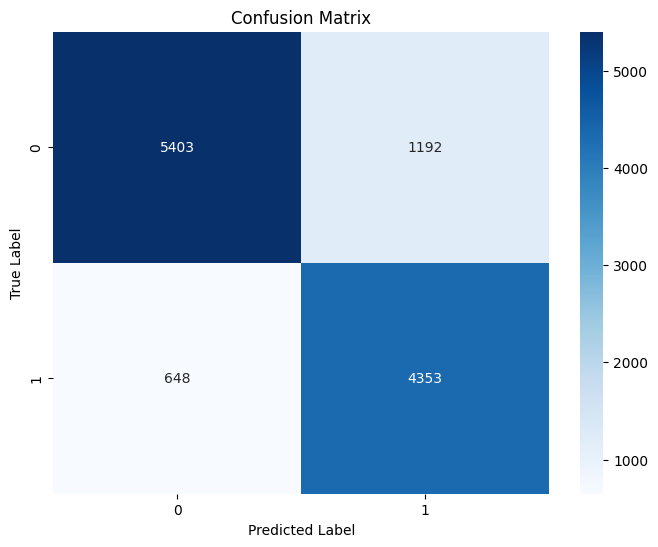

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      6595
           1       0.79      0.87      0.83      5001

    accuracy                           0.84     11596
   macro avg       0.84      0.84      0.84     11596
weighted avg       0.85      0.84      0.84     11596

Model Accuracy: 0.8413245946878234


In [ ]:
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = y_val

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred_classes))

accuracy = accuracy_score(y_true, y_pred_classes)
print("Model Accuracy:", accuracy)
